                                                            Joseph High
                                                            UNI: jph2185
### Problem 2 Code & Results

In [1]:
import numpy as np
import cvxpy as cvx
import gurobi as grb
import matplotlib.pyplot as plt

In [2]:
# US_3-MONTH_T-BILLS US_GOVN_LONG_BONDS SP_500 WILSHIRE_5000 :=
X = np.matrix([
    [1984, 1.103, 1.159, 1.061, 1.030],
    [1985, 1.080, 1.366, 1.316, 1.326],
    [1986, 1.063, 1.309, 1.186, 1.161],
    [1987, 1.061, 0.925, 1.052, 1.023],
    [1988, 1.071, 1.086, 1.165, 1.179],
    [1989, 1.087, 1.212, 1.316, 1.292],
    [1990, 1.080, 1.054, 0.968, 0.938],
    [1991, 1.057, 1.193, 1.304, 1.342],
    [1992, 1.036, 1.079, 1.076, 1.090],
    [1993, 1.031, 1.217, 1.100, 1.113],
    [1994, 1.045, 0.889, 1.012, 0.999]]);

n, d = np.shape(X)

L = 1 - X[:,1:n];
mu_est = -np.mean(L,0);

In [3]:
N = 11;                       # number of samples
alpha = 1 - (2/N);            # compute the alpha-significance level

$ \textrm{Compute} \ M_k $:

$\textrm{Let } X \textrm{ denote the price relative matrix. Then for each scenario } k \textrm{ let } \\ 
l_{k,j} = L_{k,j}\left(\large \frac{X_{k,j}}{\sum_{j}X_{k,j}}\right) \textrm{ where } X_{k,j} \textrm{ is the relative price for asset } j \textrm{ in scenario } k$

$\textrm{Then set} \ \ M_k =  M\left(\max\limits_{j}\big\{ l_{k,j}\big\} \ - \  \min\limits_{k}\big\{ \min\limits_{j}\big\{l_{k,j}\big\}\big\}\right)$

$\textrm{where} \ M = 1.25 \ \ \textrm{(the leverage constant)}$

In [4]:
#Determine the values of M_k for each value of gamma

Mk = np.zeros(11)
gamma = np.array([0.02, 0.04, 0.06, 0.08])
M = 1.25

A = np.zeros((11,4))
for i in range(len(L)):
    for j in range(4):
        A[i,j] = L[i,j]*(X[:,1:n][i,j]/np.sum(X[:,1:n][i,:]))

for i in range(len(A)):
    Mk[i] = M*(np.max(A[i]) - np.min(A))

In [5]:
x = cvx.Variable(4)
z = cvx.Variable(11, boolean = True)    # define z to be a 0-1 vector
x_pos = cvx.Variable(4)
x_neg = cvx.Variable(4)

x = x_pos - x_neg 
b = cvx.Variable(4, boolean = True)    #0-1 variable for x_pos

p = 1/N
M = 1.25
W = 100
C=3

obj = mu_est*x
objective = cvx.Maximize(obj);

max_return = np.zeros(4)
res = np.zeros((4,6))

for i in range(4):
    constraints = [];
    constraints += [L*x - Mk*z <= gamma[i]]
    constraints += [p*sum(z) <= (1-alpha)]
    constraints += [sum(x) == 1]
    constraints += [M*sum(x_neg) - sum(x_pos) <= 0]
    constraints += [x_pos <= W*b, x_pos >= 0]
    constraints += [x_neg <= W*(1-b), x_neg >= 0]
    
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver = cvx.GUROBI)
    
    max_return[i] = prob.value;
    res[i, :] = [gamma[i], max_return[i], x[0].value, x[1].value, x[2].value, x[3].value]

res = np.round(res, 5)
print('The optimal objective value and optimal solution for each value of gamma: \n')
print('gamma    Exp.Return*      x1*       x2*        x3*         x4*')

np.set_printoptions(formatter={'float_kind': "{:10.4f}".format})
for i in range(4):
    np.set_printoptions(formatter={'float_kind': "{:10.4f}".format})
    print('%.2f' % res[i,:].item(0), '     ', '%.4f' % res[i,:].item(1), '    ', '%.4f' % res[i,:].item(2), '   ', 
          '%.4f' % res[i,:].item(3), '   ', '%.4f' % res[i,:].item(4), '    ', '%.4f' % res[i,:].item(5), '   ')

prob.status

Using license file /Users/joehigh/gurobi.lic
The optimal objective value and optimal solution for each value of gamma: 

gamma    Exp.Return*      x1*       x2*        x3*         x4*
0.02       0.4281      -3.8674     1.6616     3.3384      -0.1326    
0.04       0.4376      -4.0000     1.6480     3.3520      0.0000    
0.06       0.4390      -4.0000     1.4154     3.5846      0.0000    
0.08       0.4404      -4.0000     1.1828     3.8172      0.0000    


'optimal'

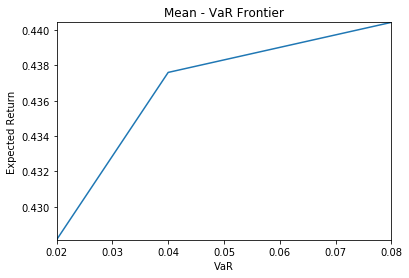

In [6]:
# Plot the mean-VaR frontier

plt.title('Mean - VaR Frontier')
plt.xlabel('VaR')
plt.ylabel('Expected Return')
plt.plot(gamma, max_return)
plt.autoscale(enable=True, tight=True)
#plt.axis([0.02,0.08,0.350,0.400])
plt.show()